# How to use `for` loop

## Introduction
With the while loop we can execute a set of nodes as long as the condition is true. In this tutorial, you will learn how to use `for` loop in WorkGraph.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow: for
Suppose we want to calculate:
```python
# start for block
total = 0
for i in range(10):
    n = i*2
    total = total + n
# end for block
z = total+1
```

### Create node
We first create the nodes to do the calculation.

In [2]:
from aiida_workgraph import node, WorkGraph
from aiida.engine import calcfunction
from aiida.orm import Int, Bool

# define multiply node for n = i*2
@node.calcfunction()
def multiply(x, y):
    return x*y

# define add node for total = total + n
@node.calcfunction()
def add(x, y):
    return x + y

# Create a WorkGraph will loop the a sequence
@node.group(outputs = [["ctx", "total", "result"]])
def add_multiply_for(sequence):
    wg = WorkGraph("add_multiply_for")
    # tell the engine that this is a `for` workgraph
    wg.workgraph_type = "FOR"
    # the sequence to be iter
    wg.sequence = sequence
    # set a context variable before running.
    wg.ctx = {"total": 0}
    multiply1 = wg.nodes.new(multiply, name="multiply1", x="{{ i }}", y=2)
    add1 = wg.nodes.new(add, name="add1", x="{{ total }}")
    # update the context variable
    add1.to_ctx = [["result", "total"]]
    wg.links.new(multiply1.outputs[0], add1.inputs[1])
    # don't forget to return the workgraph
    return wg

### Create the workflow
Now, let'use the `add_multiply_while`  node in the workflow.

In [3]:
wg = WorkGraph("test_for")
for1 = wg.nodes.new(add_multiply_for, sequence=range(5))
add1 = wg.nodes.new(add, y=Int(1))
wg.links.new(for1.outputs[0], add1.inputs[0])
wg.submit(wait=True)

[INFO] 2023-08-03 22:40:51 nodetree: Create NodeTree: test_for


### Check status and results


In [4]:
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add1   :   {}'.format(add1.node.outputs.result.value))

State of WorkGraph:   FINISHED
Result of add1   :   21


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

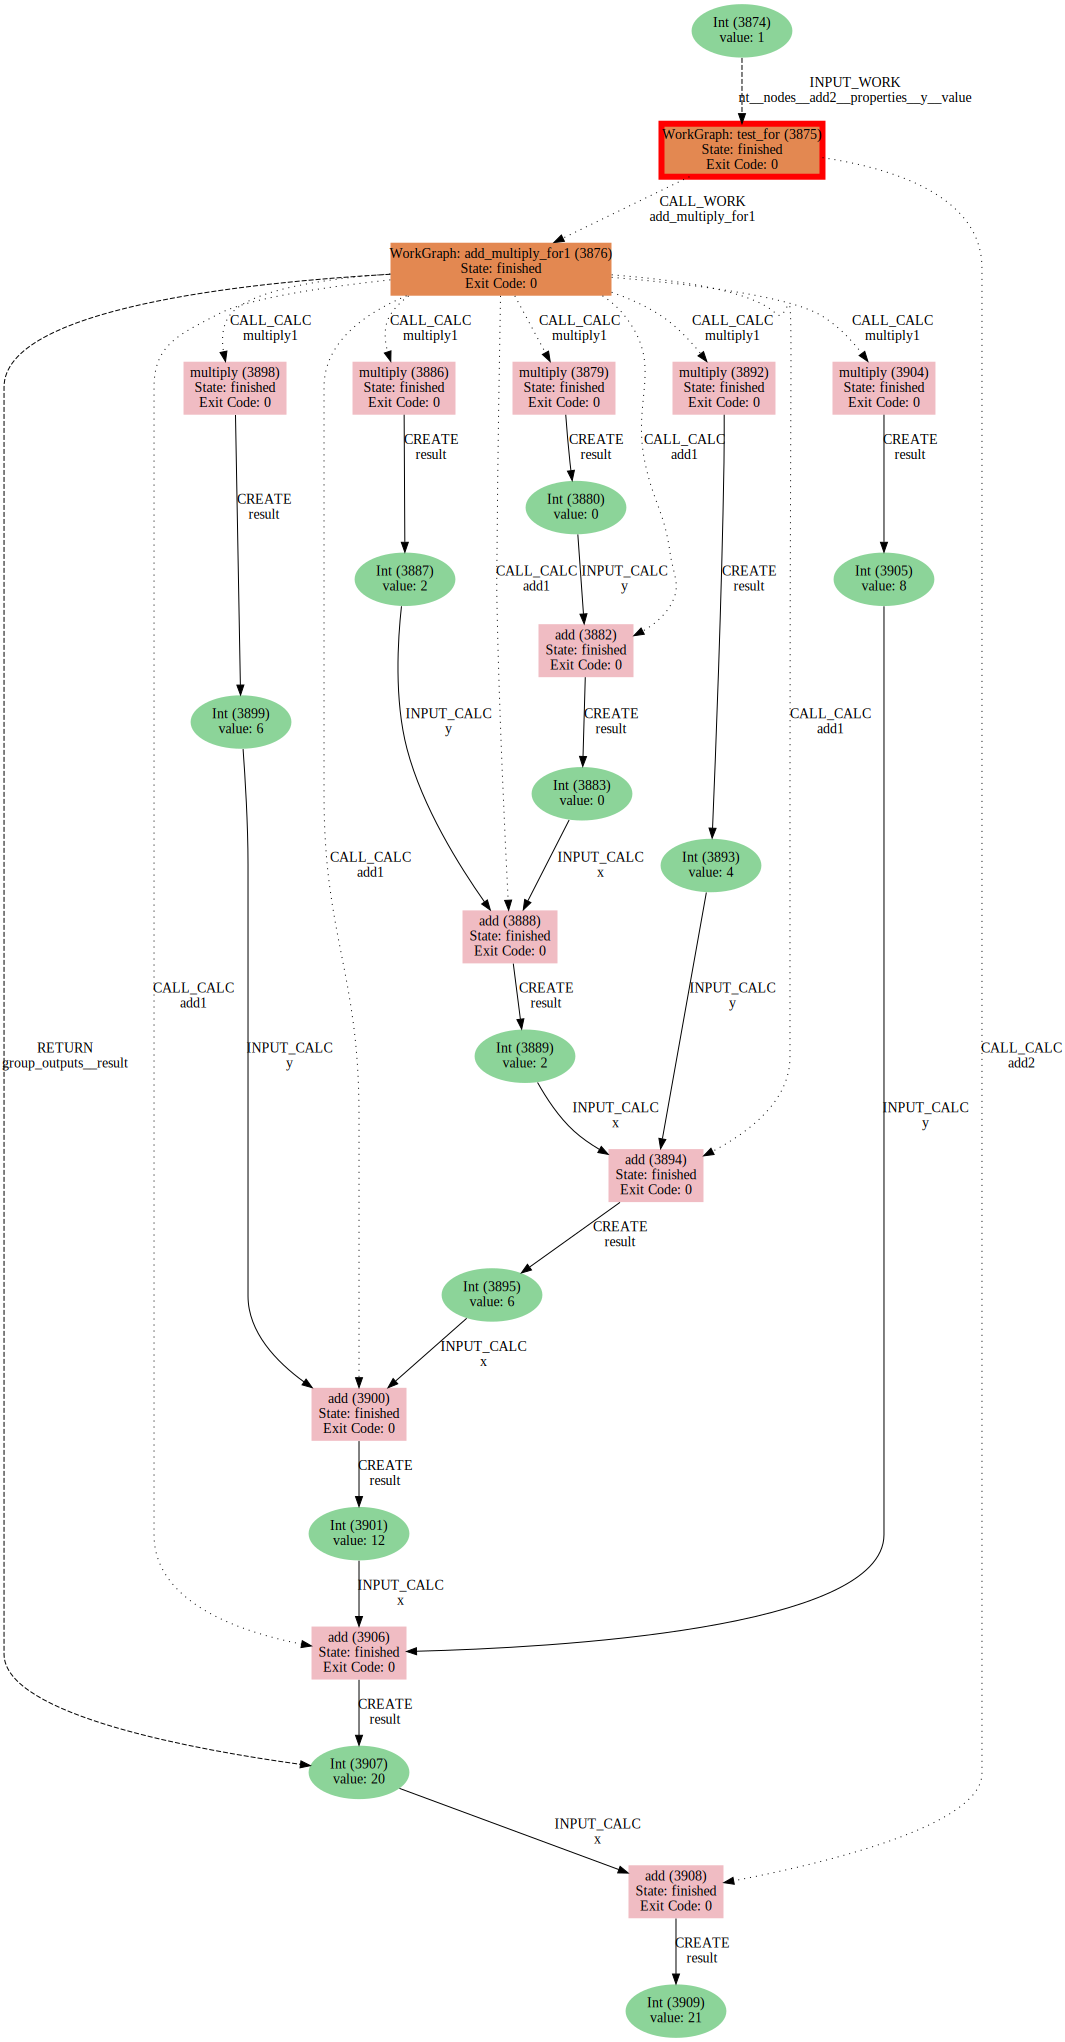

In [5]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

The problem of the `for` loop is that the provanence is not keep. Because we pass a a list as the input. And we generate a new data by slicing the list.